In [1]:
import torch
import os
import random
import utils
import data_utils
import json

import cbm
import plots

In [2]:
# change this to the correct model dir, everything else should be taken care of
load_dir = "saved_models/cub_lf_cbm"
device = "cuda"

with open(os.path.join(load_dir, "args.txt"), "r") as f:
    args = json.load(f)
dataset = args["dataset"]
_, target_preprocess = data_utils.get_target_model(args["backbone"], device)
model = cbm.load_cbm(load_dir, device)

In [3]:
val_d_probe = dataset+"_val"
cls_file = data_utils.LABEL_FILES[dataset]

val_data_t = data_utils.get_data(val_d_probe, preprocess=target_preprocess)
val_pil_data = data_utils.get_data(val_d_probe)

In [4]:
with open(cls_file, "r") as f:
    classes = f.read().split("\n")

with open(os.path.join(load_dir, "concepts.txt"), "r") as f:
    concepts = f.read().split("\n")

## Measure accuracy

In [5]:
accuracy = utils.get_accuracy_cbm(model, val_data_t, device)
print("Accuracy: {:.2f}%".format(accuracy*100))

100%|██████████| 12/12 [00:31<00:00,  2.62s/it]

Accuracy: 74.59%


## Show final layer weights for some classes

You can build a Sankey diagram of weights by copying the incoming weights printed below into https://sankeymatic.com/build/

In [6]:
to_show = random.choices([i for i in range(len(classes))], k=1)

for i in to_show:
    print("Output class:{} - {}".format(i, classes[i]))
    print("Incoming weights:")
    for j in range(len(concepts)):
        if torch.abs(model.final.weight[i,j])>0.05:
            print("{} [{:.4f}] {}".format(concepts[j], model.final.weight[i,j], classes[i]))

Output class:137 - Tree Swallow
Incoming weights:
a black cap and bib [0.3377] Tree Swallow
a brown and white color scheme [0.2030] Tree Swallow
a dark blue or black back [0.2671] Tree Swallow
a dark coloration [-0.2515] Tree Swallow
a duck-like bird [0.1356] Tree Swallow
a long, thin neck [0.1239] Tree Swallow
a small, blue bird [0.1502] Tree Swallow
a small, blue body [0.4982] Tree Swallow
a stout, conical bill [0.1489] Tree Swallow
a swift, acrobatic flight [0.3213] Tree Swallow
black cap and white "eyeline" [0.4911] Tree Swallow
blue wings [0.1311] Tree Swallow
blue wings with white bars [0.1563] Tree Swallow
iridescent blue-green back [1.0053] Tree Swallow
large feet [0.2509] Tree Swallow
large webbed feet [-0.6311] Tree Swallow
long, black ear tufts [-0.2503] Tree Swallow
orange-yellow legs [-0.2879] Tree Swallow
red feathers [0.1938] Tree Swallow
silky, brown feathers [-0.2549] Tree Swallow
yellowish underparts [-0.0813] Tree Swallow


In [7]:
to_show = random.choices([i for i in range(len(classes))], k=2)

top_weights, top_weight_ids = torch.topk(model.final.weight, k=5, dim=1)
bottom_weights, bottom_weight_ids = torch.topk(model.final.weight, k=5, dim=1, largest=False)

for i in to_show:
    print("Class {} - {}".format(i, classes[i]))
    out = "Highest weights: "
    for j in range(top_weights.shape[1]):
        idx = int(top_weight_ids[i, j].cpu())
        out += "{}:{:.3f}, ".format(concepts[idx], top_weights[i, j])
    print(out)
    out = "Lowest weights: "
    for j in range(bottom_weights.shape[1]):
        idx = int(bottom_weight_ids[i, j].cpu())
        out += "{}:{:.3f}, ".format(concepts[idx], bottom_weights[i, j])
    print(out + "\n")

Class 63 - Ring billed Gull
Highest weights: a yellow head:0.540, three toes on each foot:0.499, a white face and underparts:0.375, a grey back:0.362, mottled grey and white plumage:0.341, 
Lowest weights: pale pink legs:-0.690, white breast with brown spots:-0.635, a small, brown bill:-0.223, a black cap and back:-0.148, a thin, black bill:-0.126, 

Class 145 - Forsters Tern
Highest weights: orange and black wings:0.761, orange feet:0.645, a black cap and bib:0.623, white stripes on the wings:0.591, orange legs:0.463, 
Lowest weights: a yellow cap on the head:-0.360, a white rump:-0.252, a dark brown or black color:-0.235, large black bird:-0.219, yellow bar on wing:-0.191, 



In [8]:
# Some features may not have any non-zero outgoing weights, 
# i.e. these are not used by the model and should be deleted for better performance
weight_contribs = torch.sum(torch.abs(model.final.weight), dim=0)
print("Num concepts with outgoing weights:{}/{}".format(torch.sum(weight_contribs>1e-5), len(weight_contribs)))

Num concepts with outgoing weights:208/208


## Explain model reasoning for random inputs

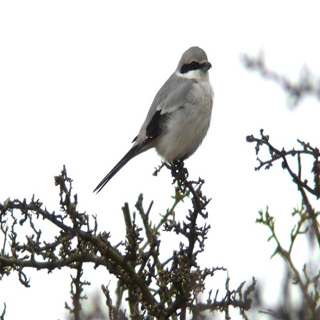

Image:3190 Gt:Great Grey Shrike, 1st Pred:Great Grey Shrike, 7.004, 2nd Pred:Loggerhead Shrike, 6.126


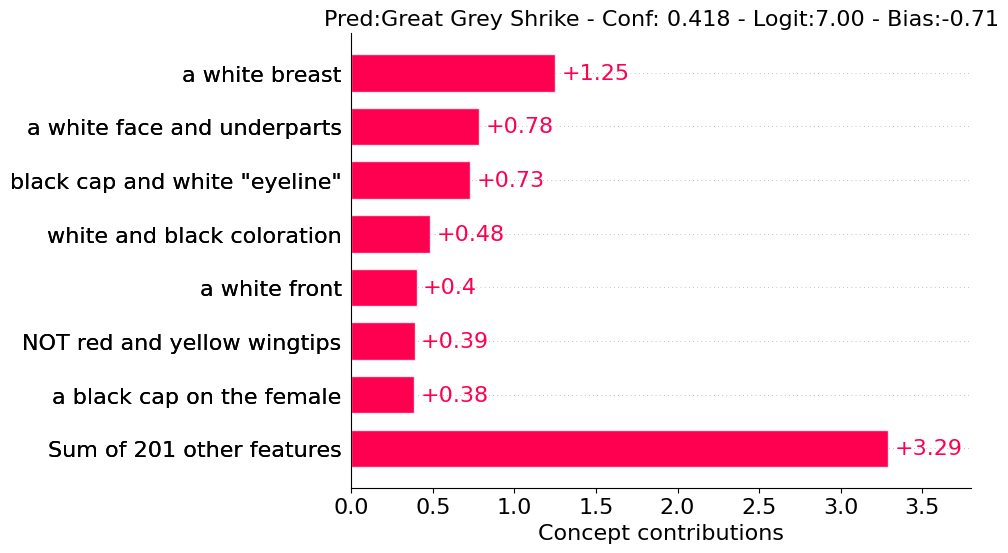

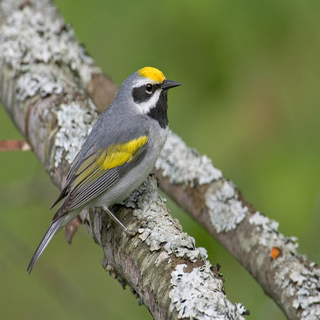

Image:4786 Gt:Golden winged Warbler, 1st Pred:Golden winged Warbler, 9.447, 2nd Pred:Myrtle Warbler, 4.388


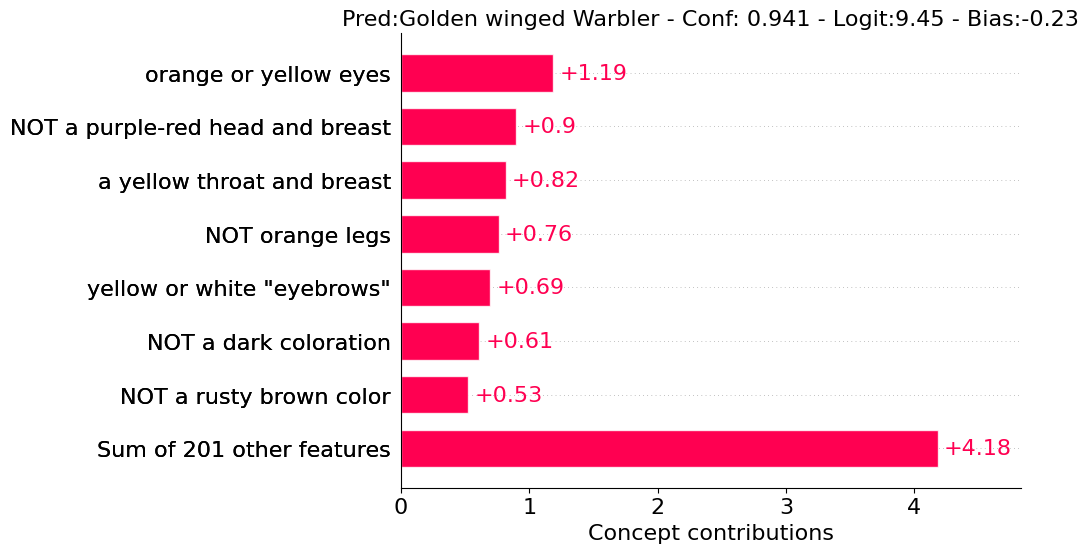

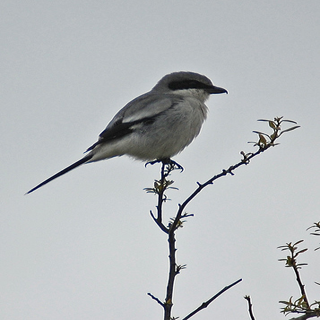

Image:3159 Gt:Loggerhead Shrike, 1st Pred:Loggerhead Shrike, 8.300, 2nd Pred:Great Grey Shrike, 8.286


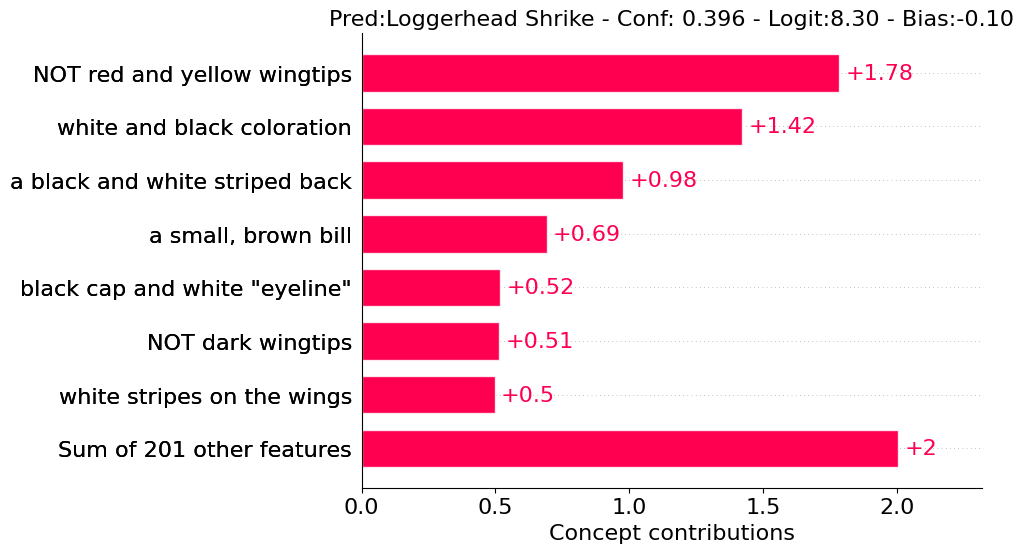

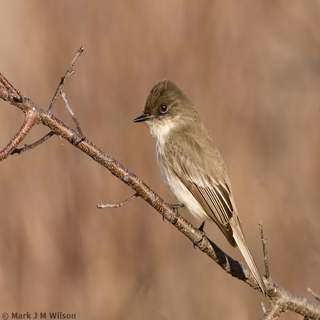

Image:2932 Gt:Sayornis, 1st Pred:Sayornis, 5.955, 2nd Pred:Olive sided Flycatcher, 5.638


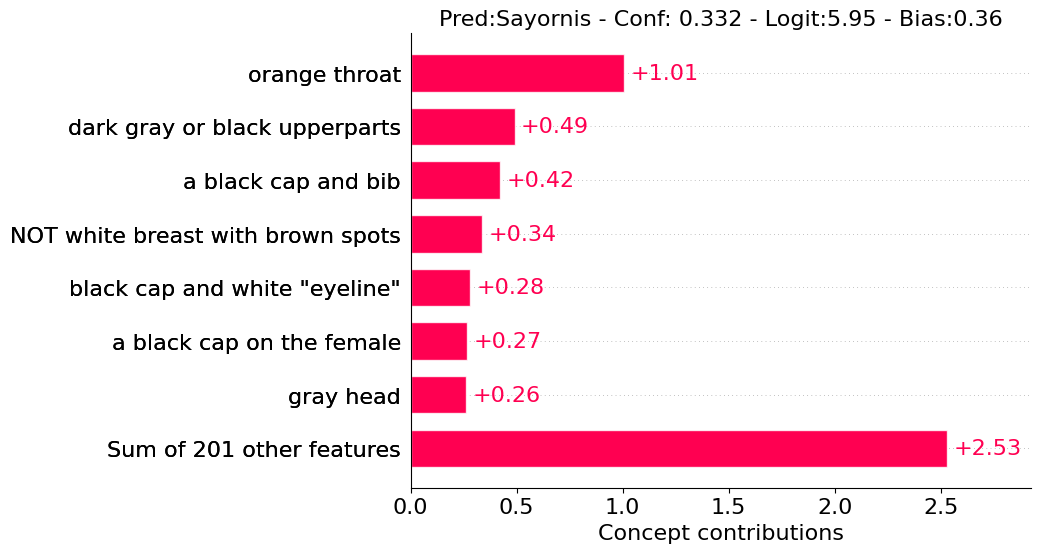

In [9]:
to_display = random.sample([i for i in range(len(val_pil_data))], k=4)

with torch.no_grad():
    for i in to_display:
        image, label = val_pil_data[i]
        x, _ = val_data_t[i]
        x = x.unsqueeze(0).to(device)
        display(image.resize([320,320]))
        
        outputs, concept_act = model(x)
        
        top_logit_vals, top_classes = torch.topk(outputs[0], dim=0, k=2)
        conf = torch.nn.functional.softmax(outputs[0], dim=0)
        print("Image:{} Gt:{}, 1st Pred:{}, {:.3f}, 2nd Pred:{}, {:.3f}".format(i, classes[int(label)], classes[top_classes[0]], top_logit_vals[0],
                                                                      classes[top_classes[1]], top_logit_vals[1]))
        
        for k in range(1):
            contributions = concept_act[0]*model.final.weight[top_classes[k], :]
            feature_names = [("NOT " if concept_act[0][i] < 0 else "") + concepts[i] for i in range(len(concepts))]
            values = contributions.cpu().numpy()
            max_display = min(int(sum(abs(values)>0.005))+1, 8)
            title = "Pred:{} - Conf: {:.3f} - Logit:{:.2f} - Bias:{:.2f}".format(classes[top_classes[k]],
                             conf[top_classes[k]], top_logit_vals[k], model.final.bias[top_classes[k]])
            plots.bar(values, feature_names, max_display=max_display, title=title, fontsize=16)